In [49]:
import hashlib
from typing import Iterable, Tuple, List, Dict, Set
from functools import lru_cache
from collections import Counter, defaultdict


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import IPython.display as ipd
import nltk
from tqdm.auto import tqdm
import crowdkit
from crowdkit.aggregation import ROVER

ModuleNotFoundError: No module named 'crowdkit'

In [10]:
train_df = pd.read_json("data/noisy_text_aggregation_train.jsonl", lines=True)
test_df = pd.read_json("data/noisy_text_aggregation_test.jsonl", lines=True)
text_data = pd.read_csv("data/noisy_text_aggregation_text_only.csv", header=None)

In [26]:
MODEL_LIST = ["qnet", "w2v", "w2v_tts"]

In [11]:
train_df.head()

,task,text,qnet,w2v,w2v_tts
0,ed0f6706f75681a7915fec15d336aca5,дамира николаевича,дамира николаевича,до мира николаевича,домера николаевича
1,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый
2,f3dba379c6280536aaa65a56c4358268,жидкову,жит куву,жит куву,жидкову
3,98962310d56cd7095d9893f5ed657f81,главатских,лалаки,главатских,главацки
4,b4f6a8d9e2eba8085d25d4122b52d55a,мошкова,мошкова,машкова,мошкова


In [12]:
test_df.head()

,task,qnet,w2v,w2v_tts
0,73aff8bc8d99278c6ca6d1ac243557e3,дели,зили,зили
1,ba8443f3cc91e56667278db36dea02b7,вектор упавнович чунула к лещенуму,виктору павловичу новокрещеному,виктору павлновичу навокрещинову оо
2,af346fae1d5686a357e32710c5d4f13e,риме менниковой,римми мельниковой,рымми мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александровик провичо,александру викторовичу,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,я ро славцов,ерославцев,ярославцев


In [13]:
text_data.head()

,0
0,алиби
1,сказка
2,найди в нете мульт стальной гигант
3,мона лиза
4,смотреть сериал восемь с половиной


In [27]:
def hash_reminder(str_, base: int=10) -> int:
    return int(hashlib.md5(str_.encode()).hexdigest(), 16) % base

train_mask = train_df['task'].apply(lambda x: hash_reminder(x, 10) <= 7)

val_df = train_df[~train_mask]
train_df = train_df[train_mask]

In [28]:
def edit_distance(ref: Iterable, hyp: Iterable) -> int:
    """
    dummy levenshtein implementation O(3^n)
    """
    if not ref:
        return len(hyp)
    if not hyp:
        return len(ref)
    return min(
        edit_distance(ref[1:], hyp[1:]) + (ref[0] != hyp[0]), # Correct / Insertion
        edit_distance(ref, hyp[1:]) + 1, # Deletion
        edit_distance(ref[1:], hyp) + 1 # Substitution
    )


def edit_distance(ref: Iterable, hyp: Iterable, plot: bool=False) -> int:
    """
    dynamic programming levenshtein implementation O(n^2)
    """

    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)

    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)

    for i, r in enumerate(hyp, start=1):
        for j, h in enumerate(ref, start=1):
            dist[i, j] = min(
                dist[i - 1, j - 1] + (r != h),
                dist[i, j - 1] + 1,
                dist[i - 1, j] + 1
            )
    if plot:
        sns.heatmap(
            pd.DataFrame(
                dist,
                index=[' '] + list(hyp),
                columns=[' '] + list(ref)
            ),
            annot=True,
            cmap='coolwarm_r',
            linewidth=2
        )
        plt.tick_params(
            axis='both', which='major', labelsize=14, left=False, labelbottom=False,
            bottom=False, top=False, labeltop=True
        )
        plt.yticks(rotation=0)

    return dist[-1, -1]

In [29]:
def error_rate(refs: Iterable[Iterable], hyps: Iterable[Iterable]) -> float:
    """
    ignoring hypotheses with empty references
    """

    wrong_words, all_words = 0, 0

    for ref, hyp in tqdm(zip(refs, hyps), total=len(refs)):
        if len(ref) > 0:
            wrong_words += edit_distance(ref, hyp)
            all_words += len(ref)
        else:
            continue
    return wrong_words / all_words

5

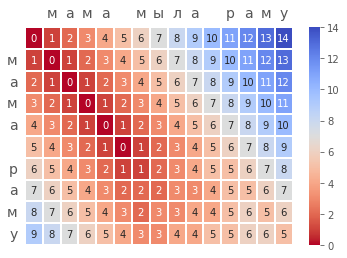

In [30]:
edit_distance('мама мыла раму', 'мама раму', plot=True)

In [36]:
def error_rate(refs: Iterable[Iterable], hyps: Iterable[Iterable]) -> float:
    """
    ignoring hypotheses with empty references
    """

    wrong_words, all_words = 0, 0

    for ref, hyp in tqdm(zip(refs, hyps), total=len(refs)):
        if len(ref) > 0:
            wrong_words += edit_distance(ref, hyp)
            all_words += len(ref)
        else:
            continue
    return wrong_words / all_words
def wer(refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Word Error Rate
    """
    return error_rate(
        [ref.split() for ref in refs],
        [hyp.split() for hyp in hyps]
    )

In [37]:
error_rate('мама мыла раму', 'мама раму')

  0%|          | 0/14 [00:00<?, ?it/s]

0.4444444444444444

In [45]:
def get_rover_df(df: pd.DataFrame, model_cols: List[str], tmp_col: str="__tmp") -> pd.DataFrame:

    rover_df = df.copy()

    if "text" in rover_df.columns:
        rover_df.drop("text", axis=1, inplace=True)

    rover_df[tmp_col] = rover_df.apply(lambda row: [(model, row[model]) for model in model_cols], axis=1)

    rover_df = rover_df.drop(model_cols, axis=1).explode(tmp_col)

    return pd.DataFrame({
        "task": rover_df["task"],
        "performer": rover_df[tmp_col].apply(lambda x: x[0]),
        "text": rover_df[tmp_col].apply(lambda x: x[1])
    })

In [48]:
val_rover_df = get_rover_df(val_df, model_cols=MODEL_LIST)

In [38]:
method2wer = {model: wer(val_df[model], val_df['text']) for model in MODEL_LIST}

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

In [39]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745}

In [40]:
def get_best_transcription(ref: Iterable[str], hyps: Iterable[Iterable[str]]):
    return hyps[
        np.array([
            edit_distance(ref, hyp) for hyp in hyps
        ]).argmin()
    ]

In [41]:
oracle_hyp = val_df.apply(
    lambda row: " ".join(
        get_best_transcription(
            ref=row['text'].split(),
            hyps=[row[model].split() for model in MODEL_LIST]
        )
    ),
    axis=1
)

In [42]:
method2wer['oracle_wer'] = wer(val_df['text'], oracle_hyp)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [43]:
method2wer

{'qnet': 0.7652783922138658,
 'w2v': 0.5601030720835285,
 'w2v_tts': 0.620017745017745,
 'oracle_wer': 0.49483770043019165}

In [46]:
test_rover_df = get_rover_df(test_df, model_cols=MODEL_LIST)

In [47]:
test_result = (
    ROVER(
        tokenizer=lambda x: list(x),
        detokenizer=lambda s: "".join(s),
        silent=False
    )
    .fit_predict(test_rover_df)
    .reset_index()
    .rename({'agg_text': 'prediction'}, axis=1)
)

NameError: name 'ROVER' is not defined